<IPython.core.display.Javascript object>


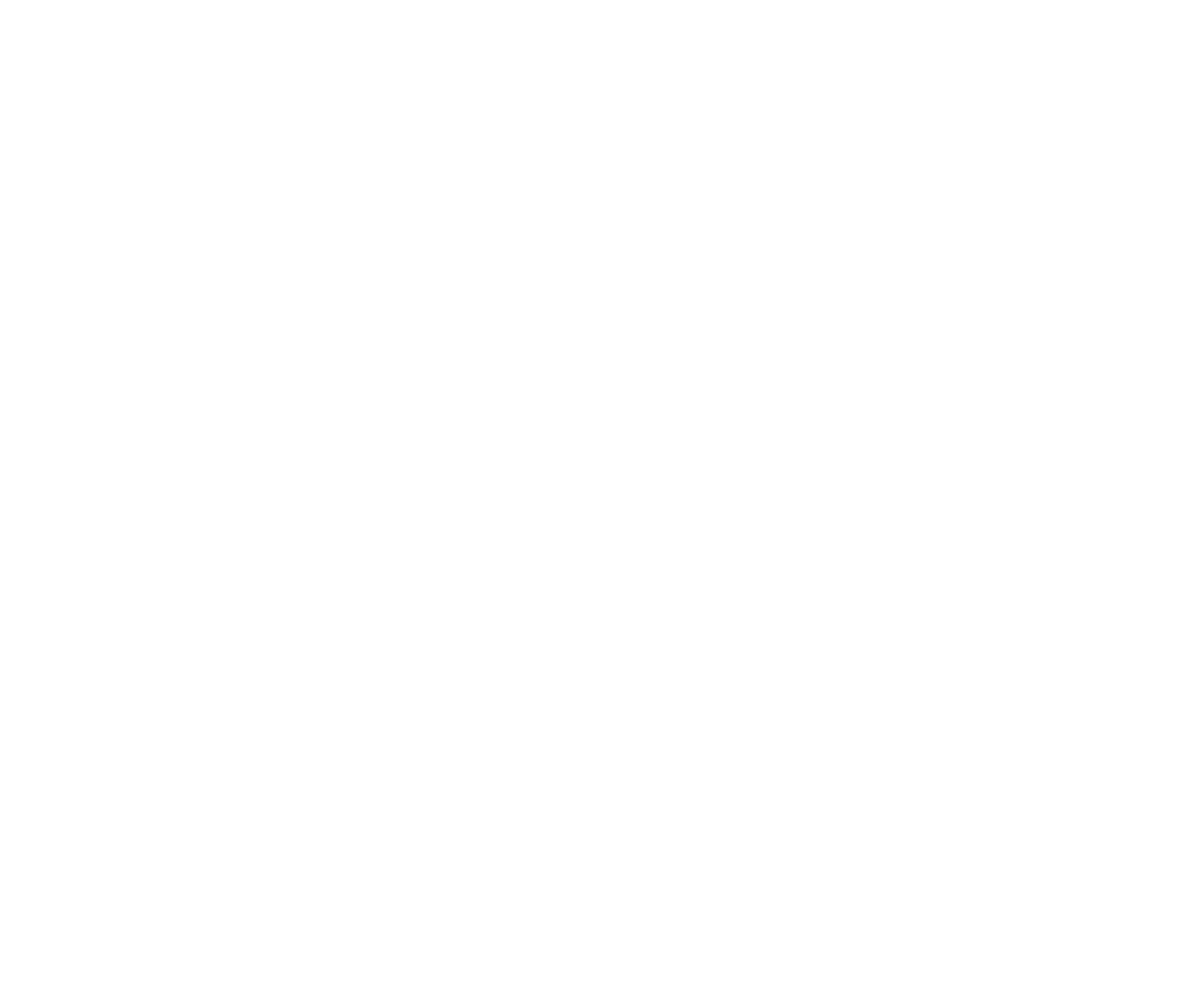

In [10]:
%reload_ext autoreload
%autoreload 2
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import sigpy.plot as splt
from matplotlib.patches import Rectangle

plt.set_cmap('gray')
plt.rcParams['figure.figsize'] = (8, 6)

import subtle.subtle_io as suio
import subtle.subtle_loss as suloss
import subtle.subtle_metrics as sumetrics
from subtle.dnn.generators import GeneratorUNet2D, GeneratorMultiRes2D
from subtle.data_loaders import SliceLoader
from tqdm import tqdm_notebook as tqdm
from keract import get_activations, display_activations, display_heatmaps

import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

def show_img(img, title='', axis=False, vmin=None, vmax=None):
    imshow_args = {}
    
    if vmin:
        imshow_args['vmin'] = vmin
    if vmax:
        imshow_args['vmax'] = vmax
    
    im_axis = 'on' if axis else 'off'
    plt.axis(im_axis)
    plt.imshow(img, **imshow_args)
    plt.title(title, fontsize=15)

def show_comparison(img1, img2, titles=['', ''], vmin=None, vmax=None):
    fig = plt.figure(figsize=(15, 10))
    fig.tight_layout()

    fig.add_subplot(1, 2, 1)
    show_img(img1, title=titles[0], vmin=vmin, vmax=vmax)

    fig.add_subplot(1, 2, 2)
    show_img(img2, title=titles[1], vmin=vmin, vmax=vmax)
    
    plt.show()

def show_gad_comparison(img_pre, img_low, img_post, vmin=None, vmax=None, titles=['Pre contrast', 'Low contrast', 'Full Contrast']):
    fig = plt.figure(figsize=(15, 10))
    fig.tight_layout()

    fig.add_subplot(1, 3, 1)
    show_img(img_pre, title=titles[0], vmin=vmin, vmax=vmax)

    fig.add_subplot(1, 3, 2)
    show_img(img_low, title=titles[1], vmin=vmin, vmax=vmax)

    fig.add_subplot(1, 3, 3)
    show_img(img_post, title=titles[2], vmin=vmin, vmax=vmax)

    plt.show()

In [19]:
fpath_h5 = '/home/srivathsa/projects/studies/gad/tiantan/preprocess/data/NO29.h5'
ims = suio.load_file(fpath_h5)
data_zero, data_low, data_full = ims.transpose(1, 0, 2, 3)

In [20]:
ckp_file = '/home/srivathsa/projects/studies/gad/tiantan/train/checkpoints/mpr_20190711.checkpoint'
data_loader = SliceLoader(
    data_list=[fpath_h5], batch_size=1, shuffle=False, verbose=1,
    slices_per_input=7, resize=240, slice_axis=[0]
)

loss_function = suloss.mixed_loss(l1_lambda=0.3, ssim_lambda=0.3)
metrics_monitor = [suloss.l1_loss, suloss.ssim_loss, suloss.mse_loss]
    
model = GeneratorUNet2D(
    num_channel_output=1, num_channel_first=32, num_poolings=3,
    loss_function=loss_function, metrics_monitor=metrics_monitor,
    batch_norm=False, verbose=1, checkpoint_file=ckp_file,
    img_rows=240, img_cols=240, num_channel_input=14
)

# model = GeneratorMultiRes2D(
#     num_channel_output=1, num_channel_first=32, num_poolings=3,
#     loss_function=loss_function, metrics_monitor=metrics_monitor,
#     batch_norm=False, verbose=1, checkpoint_file=ckp_file,
#     img_rows=240, img_cols=240, num_channel_input=14
# )

model.load_weights()

Building standard model...
Tensor("input_3:0", shape=(?, 240, 240, 14), dtype=float32)
Tensor("conv2d_43/Relu:0", shape=(?, 240, 240, 32), dtype=float32) Tensor("max_pooling2d_7/MaxPool:0", shape=(?, 120, 120, 32), dtype=float32)
Tensor("conv2d_46/Relu:0", shape=(?, 120, 120, 64), dtype=float32) Tensor("max_pooling2d_8/MaxPool:0", shape=(?, 60, 60, 64), dtype=float32)
Tensor("conv2d_49/Relu:0", shape=(?, 60, 60, 128), dtype=float32) Tensor("max_pooling2d_9/MaxPool:0", shape=(?, 30, 30, 128), dtype=float32)
conv center before add Tensor("conv2d_50/Relu:0", shape=(?, 30, 30, 128), dtype=float32)
conv center... Tensor("add_3/add:0", shape=(?, 30, 30, 128), dtype=float32)
Tensor("conv2d_53/Relu:0", shape=(?, 60, 60, 128), dtype=float32) Tensor("concatenate_7/concat:0", shape=(?, 60, 60, 256), dtype=float32)
Tensor("conv2d_56/Relu:0", shape=(?, 120, 120, 64), dtype=float32) Tensor("concatenate_8/concat:0", shape=(?, 120, 120, 192), dtype=float32)
Tensor("conv2d_59/Relu:0", shape=(?, 240, 24

<IPython.core.display.Javascript object>


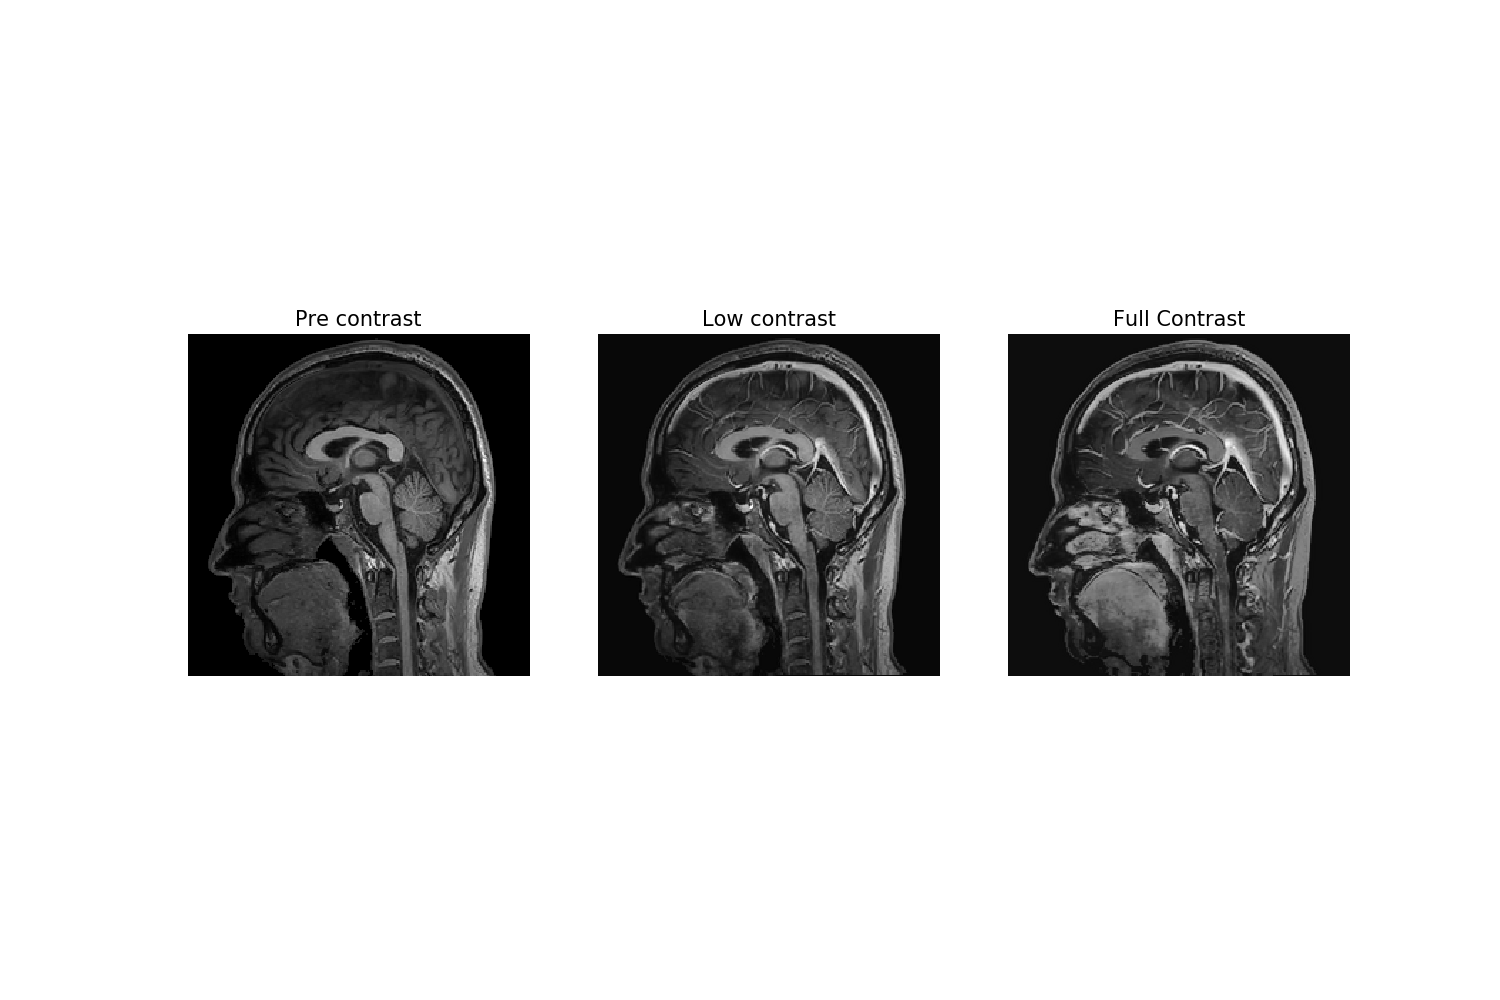

In [4]:
show_gad_comparison(data_zero[98], data_low[98], data_full[98])

<IPython.core.display.Javascript object>


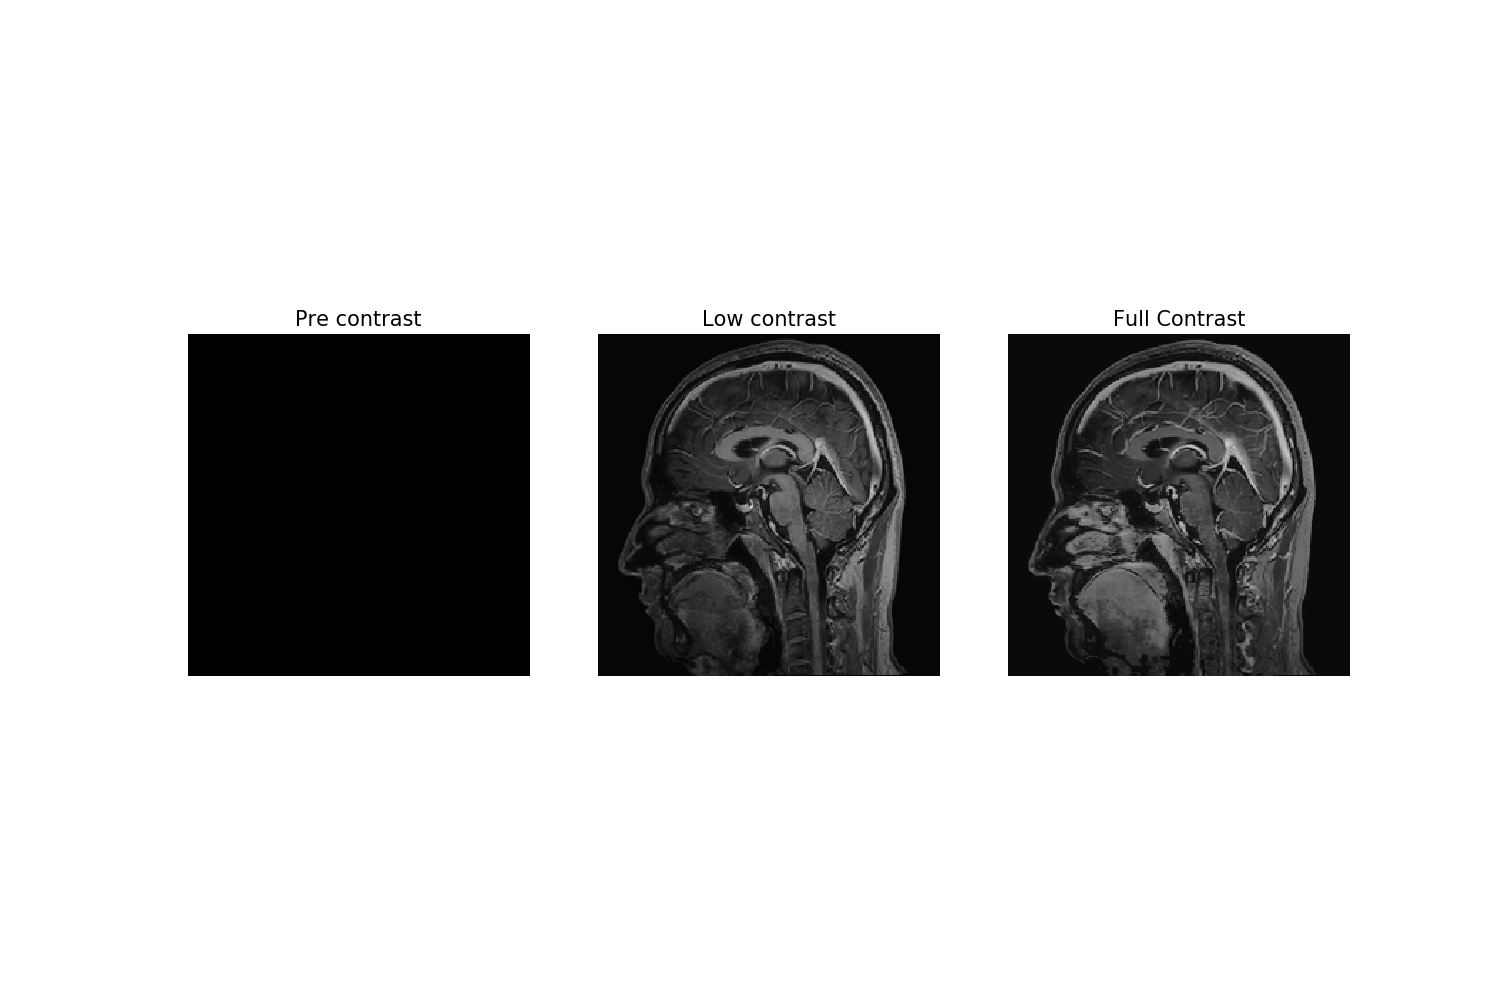

<IPython.core.display.Javascript object>


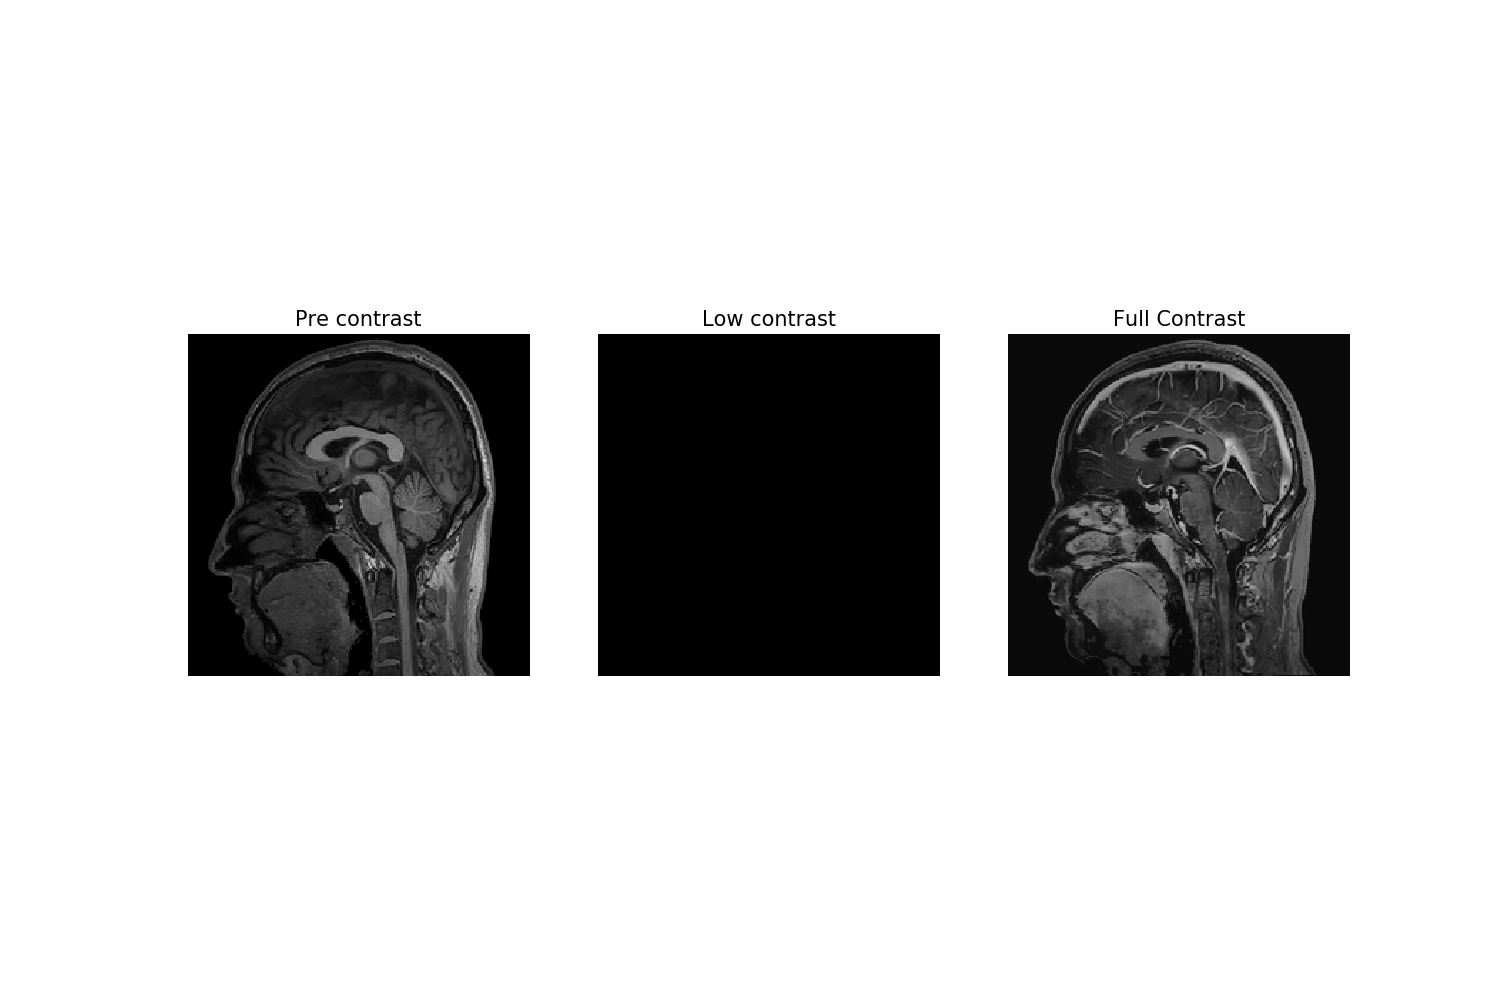

In [5]:
glen = data_loader.__len__()
# ims_mod = ims * 0.75

ims_mod_zero = np.copy(ims)
ims_mod_low = np.copy(ims)

# ims_mod_zero[:, 0] = np.random.normal(ims_mod_zero.min(), ims_mod_zero.max(), size=ims_mod_zero[:, 0].shape)
# ims_mod_low[:, 1] = np.random.normal(ims_mod_low.min(), ims_mod_low.max(), size=ims_mod_low[:, 0].shape)

ims_mod_zero[:, 0] = ims_mod_zero[:, 0] * 0
ims_mod_low[:, 1] = ims_mod_low[:, 1] * 0

show_gad_comparison(ims_mod_zero[98, 0], ims_mod_zero[98, 1], ims_mod_zero[98, 2], vmin=ims.min(), vmax=ims.max())
show_gad_comparison(ims_mod_low[98, 0], ims_mod_low[98, 1], ims_mod_low[98, 2], vmin=ims.min(), vmax=ims.max())

In [6]:
ypred = []
ypred_mod_zero = []
ypred_mod_low = []

for idx in tqdm(range(glen), total=glen):
    item, _ = data_loader.__getitem__(idx, data_npy=ims)
    item_mod_zero, _ = data_loader.__getitem__(idx, data_npy=ims_mod_zero)
    item_mod_low, _ = data_loader.__getitem__(idx, data_npy=ims_mod_low)
    ypred.extend(model.model.predict(item, verbose=0))
    ypred_mod_zero.extend(model.model.predict(item_mod_zero, verbose=0))
    ypred_mod_low.extend(model.model.predict(item_mod_low, verbose=0))
ypred = np.array(ypred)
ypred_mod_zero = np.array(ypred_mod_zero)
ypred_mod_low = np.array(ypred_mod_low)

<IPython.core.display.Javascript object>


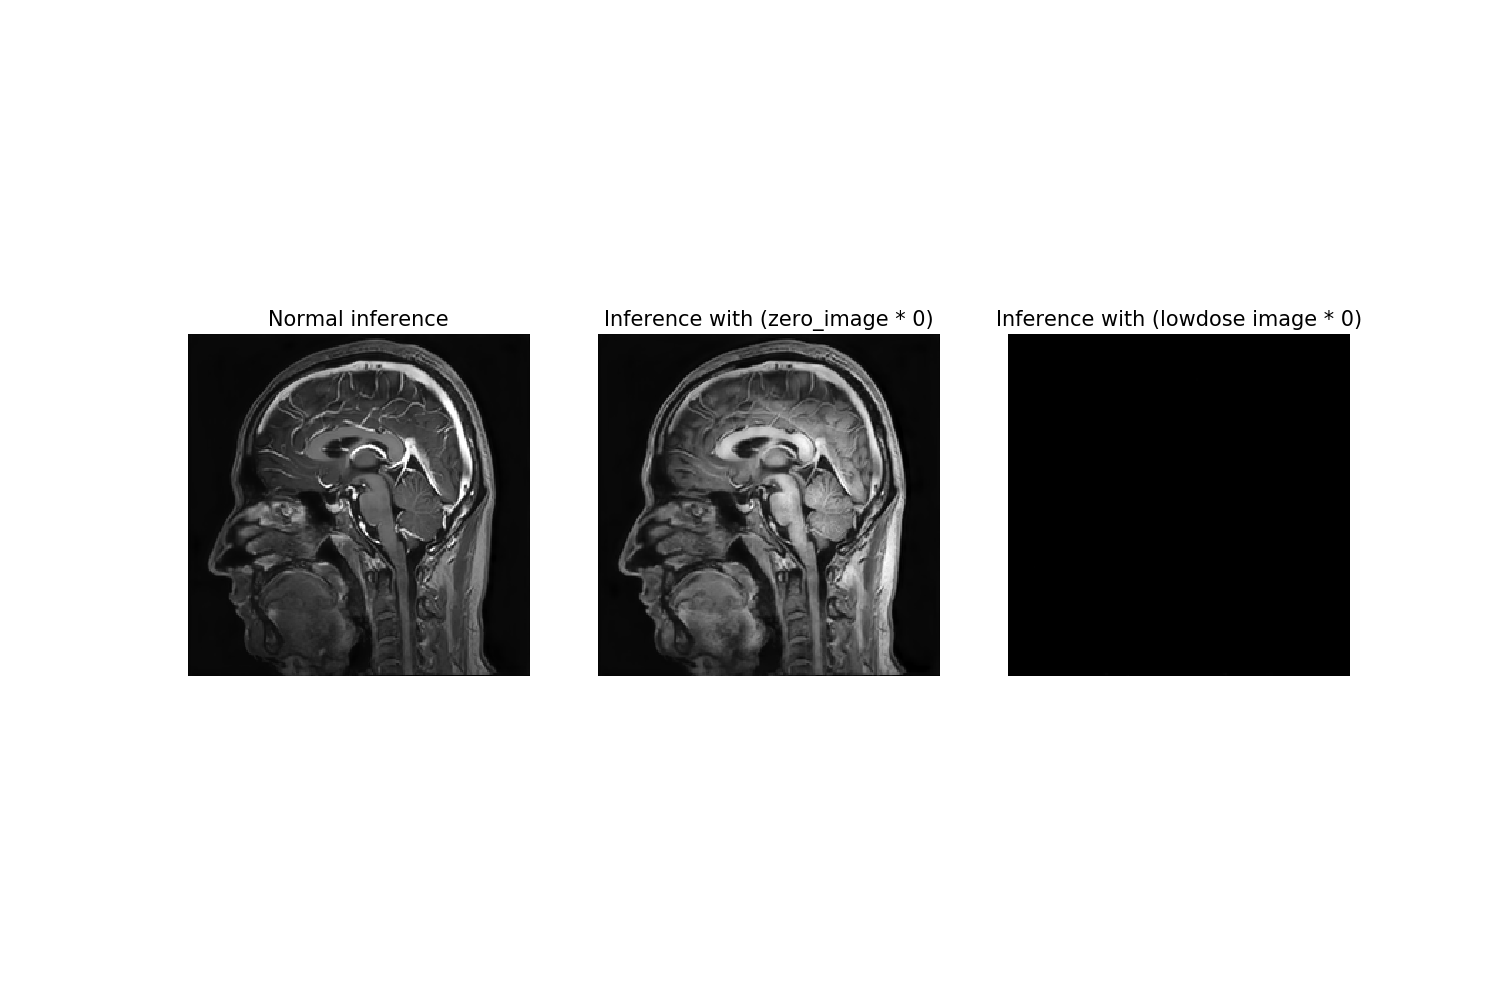

In [7]:
show_gad_comparison(
    ypred[98, ..., 0], ypred_mod_zero[98, ..., 0], ypred_mod_low[98, ..., 0], 
    vmin=ims.min(), vmax=ims.max(),
    titles=['Normal inference', 'Inference with (zero_image * 0)', 'Inference with (lowdose image * 0)']
)

### Layer activations

['input_3', 'conv2d_41', 'conv2d_42', 'conv2d_43', 'max_pooling2d_7', 'conv2d_44', 'conv2d_45', 'conv2d_46', 'max_pooling2d_8', 'conv2d_47', 'conv2d_48', 'conv2d_49', 'max_pooling2d_9', 'conv2d_50', 'add_3', 'up_sampling2d_7', 'concatenate_7', 'conv2d_51', 'conv2d_52', 'conv2d_53', 'up_sampling2d_8', 'concatenate_8', 'conv2d_54', 'conv2d_55', 'conv2d_56', 'up_sampling2d_9', 'concatenate_9', 'conv2d_57', 'conv2d_58', 'conv2d_59', 'conv2d_60']
(128, 30, 30)
max value 23.747377


<IPython.core.display.Javascript object>


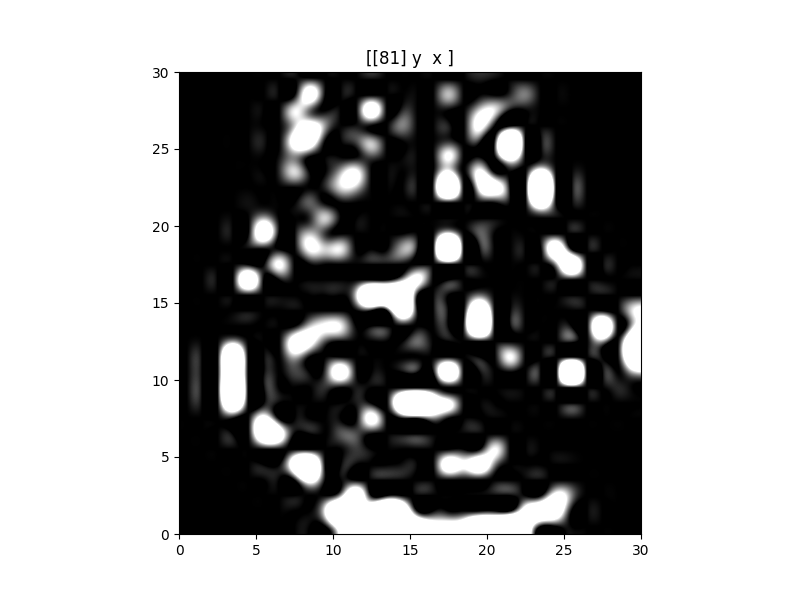

In [22]:
nw_ip, _ = data_loader.__getitem__(100)
m = model.model
lnames = [layer.name for layer in m.layers]
print(lnames)
activations = {k.split('/')[0]: v for k, v in get_activations(model.model, nw_ip).items()}
act = activations['add_3'][0].transpose(2, 0, 1)
print(act.shape)
print('max value', act.max())
splt.ImagePlot(act)

### SSIM Comparison

In [ ]:
mod_preds = []

for sf in np.linspace(0, 1, 11):
    print('Predicting for scale {}'.format(sf))
    ims_mod_zero = np.copy(ims)
    ims_mod_zero[:, 0] *= sf
    
    ypred_mod = []
    for idx in tqdm(range(glen), total=glen):
        item_mod = data_loader.__getitem__(idx, data_npy=ims_mod_zero)
        ypred_mod.extend(model.model.predict(item_mod, verbose=0))
    ypred_mod = np.array(ypred_mod)
    mod_preds.append(ypred_mod)
mod_preds = np.array(mod_preds)

ssims = []

for pred in range(mod_preds.shape[0]):
    ssims.append(sumetrics.ssim(ypred[98, ..., 0], mod_preds[pred, 98, ..., 0]))

plt.plot(np.linspace(0, 1, 11), ssims)
plt.xlabel('Scale factor')
plt.ylabel('SSIM')
plt.title('SSIM for normal prediction vs. prediction with (zero-dose * scale factor)', fontsize=15)
plt.show()